In [ ]:
!pip install -U keras-tuner

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.optimizers.legacy import Adam
import kerastuner as kt
import numpy as np
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
def load_data(train_images_path, train_labels_path, test_images_path, test_labels_path):
    # Read CSV files into Pandas DataFrames
    train_images_df = pd.read_csv(train_images_path, header=None)
    train_labels_df = pd.read_csv(train_labels_path, header=None)
    test_images_df = pd.read_csv(test_images_path, header=None)
    test_labels_df = pd.read_csv(test_labels_path, header=None)

    # Reshape to (-1,32, 32, 1)(into a 4D array that can be used as input to a convolutional neural network (CNN))
    train_images = train_images_df.to_numpy().reshape(-1, 32, 32, 1)
    train_labels = to_categorical(train_labels_df.to_numpy().flatten())  # One-hot encode labels(convert categorical labels into a binary matrix)
    test_images = test_images_df.to_numpy().reshape(-1, 32, 32, 1)  # Reshape to (-1,32, 32, 1)(number of samples, height, width, channels)
    test_labels = to_categorical(test_labels_df.to_numpy().flatten())  # One-hot encode labels
    # Return the processed data
    return train_images, train_labels, test_images, test_labels

In [ ]:
input_shape = (32, 32, 1)  #based on my dataset shape
num_classes = 29  #num of labels in the arabic character
learning_rate = 0.0010073577012265802 #result from tuner
batch_size = 32
epochs = 10
dropout_rate=0.4 #result from tuner

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
#main model after tuning parameters
def build_cnn():
    # Build the CNN model
    model = models.Sequential()

    # Convolutional layers with 32 filter
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))#maxpooling withe pool size 2x2

    # Flatten layer before fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))  # Dropout layer to prevent overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))# output layer

    # Compile the model with the Adam optimizer
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
#this function is used for tuning (using hyperparameter (hp))
import kerastuner as kt
def build_cnn_for_tuning(hp):
    # Build the CNN model
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer before fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))

    # Dropout layer with tunable rate
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model


In [ ]:
def plot_graphs(history):
    # Create a single figure for all plots
    plt.figure(figsize=(8, 4))

    # Plot Training Loss vs. Epoch
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()

    # Plot Training Accuracy vs. Epoch
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy vs. Epoch')
    plt.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


train_images_path = "/csvTrainImages 13440x1024.csv"
train_labels_path = "/csvTrainLabel 13440x1.csv"
test_images_path = "/csvTestImages 3360x1024.csv"
test_labels_path = "/csvTestLabel 3360x1.csv"
train_images, train_labels, test_images, test_labels = load_data(train_images_path, train_labels_path, test_images_path, test_labels_path)
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)

In [ ]:
train_images_path = "/content/csvTrainImages 13440x1024.csv" # defining the the pathes for the dataset files and passing it to the load function
train_labels_path = "/content/csvTrainLabel 13440x1.csv"
test_images_path = "/content/csvTestImages 3360x1024.csv"
test_labels_path = "/content/csvTestLabel 3360x1.csv"
train_images, train_labels, test_images, test_labels = load_data(train_images_path, train_labels_path, test_images_path, test_labels_path)
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)

Train Images Shape: (13440, 32, 32, 1)
Train Labels Shape: (13440, 29)


In [ ]:
#tuning learning rate and dropout rate
# Instantiate the tuner

tuner = kt.RandomSearch(build_cnn_for_tuning, objective='val_accuracy', max_trials=10)

# Perform the random search
tuner.search(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.9163690209388733

Best val_accuracy So Far: 0.9267857074737549
Total elapsed time: 00h 04m 50s
Best Hyperparameters:
Learning Rate: 0.0010845987412086886
Dropout Rate: 0.4


Epoch 1/10
420/420 [==============================] - 2s 4ms/step - loss: 3.2501 - accuracy: 0.1412 - val_loss: 2.0769 - val_accuracy: 0.3583
Epoch 2/10
420/420 [==============================] - 2s 4ms/step - loss: 1.9893 - accuracy: 0.3774 - val_loss: 1.0946 - val_accuracy: 0.6670
Epoch 3/10
420/420 [==============================] - 2s 4ms/step - loss: 1.2292 - accuracy: 0.5915 - val_loss: 0.5914 - val_accuracy: 0.8134
Epoch 4/10
420/420 [==============================] - 2s 4ms/step - loss: 0.8103 - accuracy: 0.7249 - val_loss: 0.4258 - val_accuracy: 0.8682
Epoch 5/10
420/420 [==============================] - 2s 5ms/step - loss: 0.6105 - accuracy: 0.7906 - val_loss: 0.3501 - val_accuracy: 0.8911
Epoch 6/10
420/420 [==============================] - 2s 4ms/step - loss: 0.4929 - accuracy: 0.8323 - val_loss: 0.3290 - val_accuracy: 0.8994
Epoch 7/10
420/420 [==============================] - 2s 4ms/step - loss: 0.4092 - accuracy: 0.8593 - val_loss: 0.3187 - val_accuracy: 0.9068
Epoch 

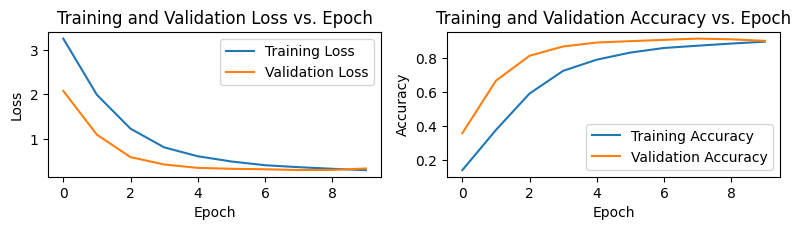

In [ ]:
# Train the model
model = build_cnn()
history = model.fit(train_images, train_labels, epochs=epochs,batch_size=batch_size, validation_data=(test_images, test_labels))
plot_graphs(history)

In [ ]:
#Task 2
#IMPORTANT NOTE: if it gave error on running, delete "untitled_project"  in content dir
from keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt

# Data augmentation parameters
def build_cnn_with_data_augmentation(hp):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer before fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))  # Dropout layer to prevent overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Data augmentation parameters
    data_gen = ImageDataGenerator(
        rotation_range=hp.Float('rotation_range', min_value=0, max_value=45, step=5),
        width_shift_range=hp.Float('width_shift_range', min_value=0, max_value=0.2, step=0.05),
        height_shift_range=hp.Float('height_shift_range', min_value=0, max_value=0.2, step=0.05),
        shear_range=hp.Float('shear_range', min_value=0, max_value=0.2, step=0.05),
        horizontal_flip=hp.Boolean('horizontal_flip'),
        fill_mode=hp.Choice('fill_mode', values=['constant', 'nearest', 'reflect', 'wrap'])
    )

    # Use the data generator for training
    train_generator = data_gen.flow(train_images, train_labels, batch_size=batch_size)

    # Train the model
    model.fit(train_generator, epochs=epochs, validation_data=(test_images, test_labels))

    return model

# Define the tuner
tuner = kt.RandomSearch(build_cnn_with_data_augmentation, objective='val_accuracy', max_trials=10)

# Search for the best hyperparameters
tuner.search(train_images, train_labels, epochs=epochs, validation_data=(test_images, test_labels))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Rotation Range: {best_hps.get('rotation_range')}")
print(f"Width Shift Range: {best_hps.get('width_shift_range')}")
print(f"Height Shift Range: {best_hps.get('height_shift_range')}")
print(f"Shear Range: {best_hps.get('shear_range')}")
print(f"Horizontal Flip: {best_hps.get('horizontal_flip')}")
print(f"Fill Mode: {best_hps.get('fill_mode')}")


Reloading Tuner from ./untitled_project/tuner0.json
Best Hyperparameters:


KeyError: 'rotation_range does not exist.'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest' #'nearest' to fill newly created pixels during augmentation with the nearest existing pixel value.
)

In [ ]:

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
# Train the model
history=model.fit(train_generator, epochs=epochs, validation_data=(test_images, test_labels))
plot_graphs(history)

In [ ]:
#Task 3, LeNet-5 arch model
def build_lenet():
    model = models.Sequential()
    #Conv 1
    model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape))
    #avg pooling 1
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv 2
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    #avg pooling 2
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv 3
    model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    #always flatten layer before fully connected layers
    model.add(layers.Flatten())
    #fully connected layer 1
    model.add(layers.Dense(84, activation='tanh'))
    model.add(layers.Dropout(dropout_rate))  # Dropout layer to prevent overfitting
    #fully connected layer 2
    model.add(layers.Dense(num_classes, activation='softmax'))
    #compiling the model with the same optimizer defined for all models
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model


In [ ]:
lenet_model=build_lenet()
res=lenet_model.fit(train_generator, epochs=epochs, validation_data=(test_images, test_labels)) #combined with data augmentation made before
plot_graphs(res)

In [ ]:
#tuning LeNet-5 model's parameters to trade-off between complexity of layers and the accuracy obtained
#Important to remove "untitled project" in content before starting

from kerastuner.engine.hyperparameters import HyperParameters

# Function to build the LeNet-5 model
def build_lenet_tuning(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=4, max_value=32, step=4),
                            kernel_size=(5, 5),
                            strides=(1, 1),
                            activation='tanh',
                            input_shape=input_shape))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=8, max_value=64, step=8),
                            kernel_size=(5, 5),
                            strides=(1, 1),
                            activation='tanh'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=16, max_value=128, step=16),
                            kernel_size=(5, 5),
                            strides=(1, 1),
                            activation='tanh'))

    model.add(layers.Flatten())

    model.add(layers.Dense(hp.Int('dense1_units', min_value=16, max_value=128, step=16), activation='tanh'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the Keras Tuner RandomSearch tuner
tuner = kt.RandomSearch(
    build_lenet_tuning,
    objective='val_accuracy',
    directory='lenet_tuner',
    project_name='lenet_tuning'
)

# Perform the hyperparameter search
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=epochs)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"conv1_filters: {best_hps.get('conv1_filters')}")
print(f"conv2_filters: {best_hps.get('conv2_filters')}")
print(f"conv3_filters: {best_hps.get('conv3_filters')}")
print(f"dense1_units: {best_hps.get('dense1_units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")



In [ ]:
#modified lenet model
def build_lenet2():
    model = models.Sequential()
    #Conv 1
    model.add(layers.Conv2D(12, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape))
    #avg pooling 1
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv 2
    model.add(layers.Conv2D(24, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    #avg pooling 2
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv 3
    model.add(layers.Conv2D(112, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    #always flatten layer before fully connected layers
    model.add(layers.Flatten())
    #fully connected layer 1
    model.add(layers.Dense(64, activation='tanh'))
    model.add(layers.Dropout(0.4))  # Dropout layer to prevent overfitting
    #fully connected layer 2
    model.add(layers.Dense(num_classes, activation='softmax'))
    #compiling the model with the same optimizer defined for all models
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
lenet_model2=build_lenet2()
res2=lenet_model2.fit(train_generator, epochs=epochs, validation_data=(test_images, test_labels)) #combined with data augmentation made before
plot_graphs(res2)

In [ ]:
base_model=pretrained_model()
# Train the model on your Arabic handwritten character dataset
evaluation=base_model.fit(train_images, train_labels, epochs=epochs, validation_data=(test_images, test_labels))
plot_graphs(evaluation)

58889256/58889256 [==============================] - 3s 0us/step


NameError: name 'num_classes' is not defined

In [ ]:
#task 4
import tensorflow as tf
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers.experimental import preprocessing

# Function to build VGG16-based model
def pretrained_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    # Unfreeze some top layers for fine-tuning
    for layer in base_model.layers[:-1]:
        layer.trainable = True #unfreezes the last four convolutional blocks of VGG16 for fine-tuning.
    # Create a new model and add VGG16 as a base
    model = Sequential()
    model.add(preprocessing.Rescaling(1./255, input_shape=(32, 32, 1)))  # Normalize pixel values
    model.add(tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))  # Convert to RGB
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

